In [ ]:
!pip install qiskit


In [ ]:
import math
import numpy as numpy
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Shor


In [ ]:

N=15
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots = 1024)
shor = Shor(quantum_instance=quantum_instance)
result  = shor.factor(N)
print(f"The list of factors of {N} as computed by Shor is {result.factors[0]}")

The list of factors of 15 as computed by Shor is [3, 5]


### Shor epanded

In [ ]:
!pip install pylatexenc


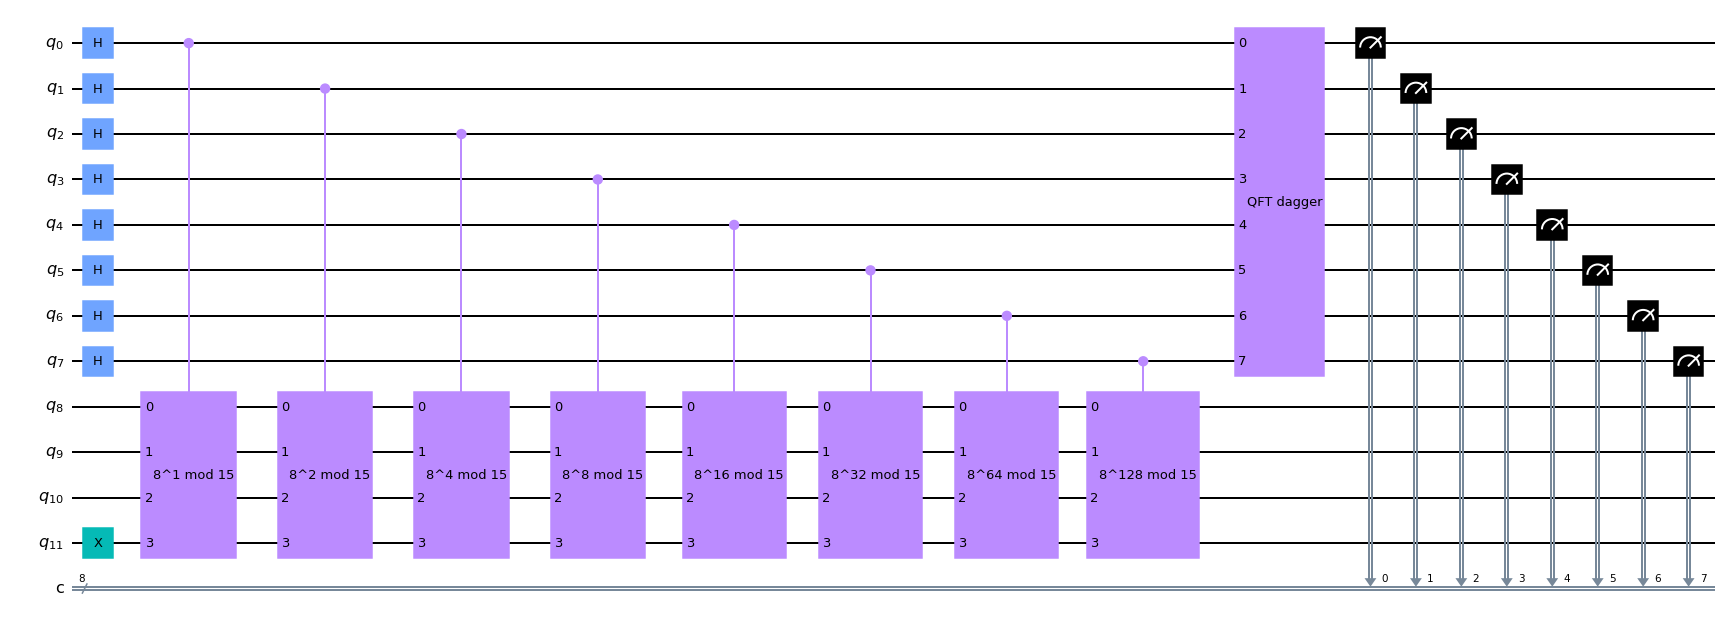

In [ ]:
import math
import numpy as np
from qiskit import Aer, QuantumCircuit, execute
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Shor

import pylatexenc

backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
# N=15; a = 7
def c_amod15(a, power):
  U = QuantumCircuit(4)
  for iteration in range(power):
    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)
    for q in range(4):
      U.x(q)
  U = U.to_gate()
  U.name = "%i^%i mod 15" % (a, power)
  c_U = U.control()
  return c_U

n_count = 8
a = 8 #M

def qft_dagger(n):
  qc = QuantumCircuit(n)
  for qubit in range(n//2):
    qc.swap(qubit, n-qubit-1)
  for j in range(n):
    for m in range(j):
      qc.cp(-np.pi/float(2**(j-m)), m, j) # not cu1
    qc.h(j)
  qc.name = "QFT dagger"
  return qc

qft_dagger(5).draw(output='mpl', fold=-1)

qc = QuantumCircuit(n_count + 4, n_count)

for q in range(n_count):
  qc.h(q)

qc.x(3+n_count)

for q in range(n_count):
  qc.append(c_amod15(a, 2**q), [q]+[i+n_count for i in range(4)])

qc.append(qft_dagger(n_count), range(n_count))

qc.measure(range(n_count), range(n_count))

qc.draw(output='mpl', fold=-1)

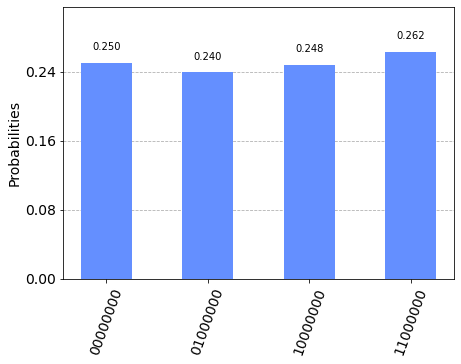

In [ ]:
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()

from qiskit.tools.visualization import plot_histogram

plot_histogram(counts)

In [ ]:
import pandas as pd
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  00000000(bin) =   0(dec)    0/256 = 0.00


In [ ]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.25      1/4            4
2   0.50      1/2            2
3   0.00      0/1            1


In [ ]:
N = 15

In [ ]:
from random import randint
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

15


In [ ]:
from math import gcd # greatest common divisor
gcd(a, N)

15

In [ ]:
from qiskit import *
from qiskit.quantum_info import Operator
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=1)
    result = aer_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [ ]:
from fractions import Fraction
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r

Register Reading: 11000000
Corresponding Phase: 0.750000


Fraction(3, 4)

In [ ]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

4


In [ ]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[1, 1]


In [ ]:
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 00000000
Corresponding Phase: 0.000000
Result: r = 1

Attempt 2:
Register Reading: 11000000
Corresponding Phase: 0.750000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


In [ ]:
#credits : qiskit